In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ajaykumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# pip install pyLDAvis
# pip install gensim
# pip install spacy==2.2.0

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [ ]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

pprint(data[:2])

['From: (where s my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ',
 'From: (Guy Kuo) Subject: SI Clock Poll - Final Call Summary: Final call for '
 'SI clock reports Keywords: SI,acceleration,clock,upgrade Article-I.D.: '
 'shelley.1qvfo9INNc3s Organization: University of Washington Lines: 11 '
 'NNTP-Posting-Host: carson.u.washingto

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])


[['from', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['car', 'nntp_posting', 'host', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)]]


If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [ ]:
id2word[0]

'addition'

In [ ]:
corpus[:1][0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 5),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 1)]

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('neighborhood', 1),
  ('nntp_posting', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('sport', 1),
  ('thank', 1),
  ('wonder', 1),
  ('year', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"evidence" + 0.031*"believe" + 0.030*"reason" + 0.027*"claim" + '
  '0.021*"say" + 0.021*"sense" + 0.019*"faith" + 0.019*"exist" + '
  '0.014*"people" + 0.014*"science"'),
 (1,
  '0.034*"write" + 0.023*"article" + 0.022*"line" + 0.021*"know" + '
  '0.019*"make" + 0.019*"go" + 0.019*"say" + 0.018*"get" + 0.017*"think" + '
  '0.016*"see"'),
 (2,
  '0.091*"season" + 0.078*"fan" + 0.061*"trade" + 0.044*"vote" + 0.042*"pen" + '
  '0.038*"star" + 0.030*"helmet" + 0.025*"devil" + 0.024*"remind" + '
  '0.021*"penalty"'),
 (3,
  '0.133*"technology" + 0.036*"technical" + 0.035*"industry" + '
  '0.035*"development" + 0.032*"develop" + 0.029*"resource" + 0.027*"medical" '
  '+ 0.024*"schedule" + 0.022*"solid" + 0.021*"nuclear"'),
 (4,
  '0.035*"kill" + 0.021*"side" + 0.019*"attack" + 0.018*"israeli" + '
  '0.017*"fire" + 0.017*"bike" + 0.017*"death" + 0.017*"war" + 0.017*"man" + '
  '0.015*"woman"'),
 (5,
  '0.092*"ground" + 0.043*"task" + 0.032*"regularly" + 0.030*"hook" + '
  '0.02

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.643598637589042

Coherence Score:  0.44868845329425444


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.328874 -0.086072       1        1  36.891814
16    -0.295193  0.086724       2        1  17.645877
18    -0.219091 -0.020999       3        1   9.087457
9     -0.202543 -0.129529       4        1   6.546767
15    -0.138704  0.285740       5        1   6.486947
0     -0.232490 -0.241185       6        1   5.870546
4     -0.060681  0.043947       7        1   3.738310
10    -0.088052  0.227023       8        1   3.659688
19     0.015335 -0.109814       9        1   1.636868
13     0.071908  0.044875      10        1   1.597497
11     0.031237  0.075047      11        1   1.331517
17     0.119404  0.003556      12        1   0.993768
8      0.119306  0.005275      13        1   0.875789
3      0.146778 -0.033549      14        1   0.716643
12     0.151618 -0.019674      15        1   0.709163
7      0.167843 -0.023635      16        1   0.608651
2      0.162308 -0.014715      17        1   0.563443
6      0.184419 -0.027261      18        1   0.413067
14     0.192860 -0.035457      19        1   0.350880
5      0.202611 -0.030296      20        1   0.275309, topic_info=              Term          Freq         Total Category  logprob  loglift
184          write  14017.000000  14017.000000  Default  30.0000  30.0000
32            year   4523.000000   4523.000000  Default  29.0000  29.0000
286            say   8930.000000   8930.000000  Default  28.0000  28.0000
623            key   2627.000000   2627.000000  Default  27.0000  27.0000
125         people   7999.000000   7999.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
13566       wiring      0.042323      1.240388  Topic20 -11.1757   2.5172
16377  ground_wire      0.042318      1.240353  Topic20 -11.1758   2.5171
10976      breaker      0.042317      1.240356  Topic20 -11.1759   2.5171
3361       connect      0.042319      1.240435  Topic20 -11.1758   2.5171
4701      physical      0.042317      1.240513  Topic20 -11.1759   2.5170

[841 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2923     14  0.960158  abstract
1211      3  0.998748    accept
1004     16  0.978621  accuracy
1578      1  0.035538    action
1578      4  0.739474    action
...     ...       ...       ...
32        1  0.173767      year
32        3  0.004200      year
32        5  0.672298      year
32        9  0.012601      year
32       11  0.136847      year

[1098 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 17, 19, 10, 16, 1, 5, 11, 20, 14, 12, 18, 9, 4, 13, 8, 3, 7, 15, 6])

In [ ]:
import os
os.environ.update({'MALLET_HOME':r'C:/Users/Lenovo/Desktop/mallet-2.0.8'})

In [ ]:
## Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'C:/Users/Lenovo/Desktop/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(14,
  [('drive', 0.034160504468538765),
   ('card', 0.026970013156103978),
   ('problem', 0.026130744454021686),
   ('system', 0.024928548745633536),
   ('driver', 0.018804155514222202),
   ('run', 0.017579276867939937),
   ('work', 0.015242934264845983),
   ('disk', 0.015220251326951867),
   ('bit', 0.014040738556457832),
   ('memory', 0.013723177425940208)]),
 (18,
  [('line', 0.02928489135385687),
   ('good', 0.028347131795407658),
   ('buy', 0.026632371459957668),
   ('price', 0.02585537068295689),
   ('sell', 0.023953058435817055),
   ('cost', 0.01596870562387804),
   ('pay', 0.015459636149291321),
   ('sale', 0.015191704846877261),
   ('offer', 0.012753529994909306),
   ('call', 0.012565978083219463)]),
 (6,
  [('window', 0.020890399084636455),
   ('image', 0.017891196560452134),
   ('file', 0.015464096251863667),
   ('program', 0.014597274713082071),
   ('display', 0.013799798897403003),
   ('software', 0.012187510835269234),
   ('application', 0.012170174404493602),
   ('vers

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

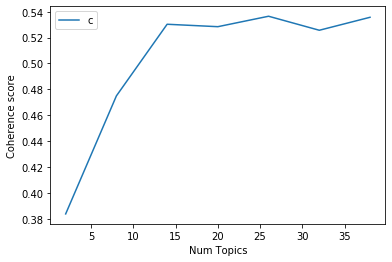

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3838
Num Topics = 8  has Coherence Value of 0.475
Num Topics = 14  has Coherence Value of 0.5303
Num Topics = 20  has Coherence Value of 0.5284
Num Topics = 26  has Coherence Value of 0.5365
Num Topics = 32  has Coherence Value of 0.5257
Num Topics = 38  has Coherence Value of 0.5357


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.041*"file" + 0.020*"image" + 0.019*"program" + 0.016*"include" + '
  '0.016*"software" + 0.015*"version" + 0.012*"system" + 0.012*"source" + '
  '0.010*"format" + 0.010*"graphic"'),
 (1,
  '0.041*"car" + 0.014*"bike" + 0.014*"buy" + 0.011*"ride" + 0.009*"drive" + '
  '0.009*"price" + 0.009*"engine" + 0.008*"turn" + 0.008*"speed" + '
  '0.007*"sell"'),
 (2,
  '0.020*"man" + 0.018*"people" + 0.014*"life" + 0.014*"love" + 0.010*"church" '
  '+ 0.009*"world" + 0.009*"die" + 0.009*"religion" + 0.009*"christian" + '
  '0.008*"live"'),
 (3,
  '0.026*"gun" + 0.022*"law" + 0.021*"state" + 0.012*"people" + '
  '0.012*"government" + 0.010*"crime" + 0.010*"case" + 0.009*"weapon" + '
  '0.008*"firearm" + 0.007*"public"'),
 (4,
  '0.057*"good" + 0.047*"time" + 0.029*"lot" + 0.023*"find" + 0.023*"make" + '
  '0.022*"work" + 0.021*"thing" + 0.019*"long" + 0.016*"book" + 0.015*"great"'),
 (5,
  '0.033*"drive" + 0.027*"card" + 0.022*"system" + 0.019*"problem" + '
  '0.018*"driver" + 0.014*"dis

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1836,"car, bike, buy, ride, drive, price, engine, tu...",From: (where s my thing) Subject: WHAT car is ...
1,1,5.0,0.1491,"drive, card, system, problem, driver, disk, wo...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,5.0,0.1176,"drive, card, system, problem, driver, disk, wo...",From: (Thomas E Willis) Subject: PB questions....
3,3,5.0,0.0926,"drive, card, system, problem, driver, disk, wo...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,10.0,0.1588,"window, problem, line, set, call, application,...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,3.0,0.3454,"gun, law, state, people, government, crime, ca...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,16.0,0.1024,"mail, post, send, information, list, group, ad...",From: (brian manning delaney) Subject: Brain T...
7,7,5.0,0.4401,"drive, card, system, problem, driver, disk, wo...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,10.0,0.0995,"window, problem, line, set, call, application,...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,5.0,0.2136,"drive, card, system, problem, driver, disk, wo...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7107,"file, image, program, include, software, versi...",From: (David B. Lewis) Subject: comp.windows.x...
1,1.0,0.5422,"car, bike, buy, ride, drive, price, engine, tu...",From: (richard welty) Subject: rec.autos: Freq...
2,2.0,0.6271,"man, people, life, love, church, world, die, r...",From: (Family Magazine Sysops) Subject: WITNES...
3,3.0,0.7178,"gun, law, state, people, government, crime, ca...",From: (Larry Cipriani) Subject: Gun Talk -- St...
4,4.0,0.6449,"good, time, lot, find, make, work, thing, long...","From: (Jeff Mason) Subject: Marvel, DC, Valian..."


In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"car, bike, buy, ride, drive, price, engine, tu...",729.0,0.0644
1.0,5.0,"drive, card, system, problem, driver, disk, wo...",1002.0,0.0886
2.0,5.0,"drive, card, system, problem, driver, disk, wo...",625.0,0.0552
3.0,5.0,"drive, card, system, problem, driver, disk, wo...",584.0,0.0516
4.0,10.0,"window, problem, line, set, call, application,...",256.0,0.0226
5.0,3.0,"gun, law, state, people, government, crime, ca...",1433.0,0.1267
6.0,16.0,"mail, post, send, information, list, group, ad...",557.0,0.0492
7.0,5.0,"drive, card, system, problem, driver, disk, wo...",475.0,0.0420
8.0,10.0,"window, problem, line, set, call, application,...",270.0,0.0239
9.0,5.0,"drive, card, system, problem, driver, disk, wo...",471.0,0.0416
